<a href="https://colab.research.google.com/github/ShivanshGupta55/Real-or-Not-NLP-with-Disaster-Tweets/blob/master/NLP_Disaster_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
train = pd.read_csv('/content/train (2).csv')
test = pd.read_csv('/content/test (2).csv')


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.shape

(7613, 5)

In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
test.shape

(3263, 4)

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
#removing emojis
import re
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [0]:
train['text']=train['text'].apply(lambda x: remove_emoji(x))

In [10]:
#removing punctuations
import string
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [0]:
train['text']=train['text'].apply(lambda x : remove_punct(x))


In [0]:
#Spelling Correction
!pip install pyspellchecker


In [0]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me please'

In [0]:
#train['text']=train['text'].apply(lambda x : correct_spellings(x))


In [0]:
sentences = train['text']
labels = train['target']

In [0]:
vocab_size = 10000
embed_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 6471

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = np.array(pad_sequences(training_sequences, maxlen = max_length, truncating = trunc_type, padding=padding_type))

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = np.array(pad_sequences(testing_sequences, maxlen = max_length, truncating=trunc_type, padding=padding_type))

In [15]:
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embed_dim, input_length = max_length),
                             tf.keras.layers.SpatialDropout1D(0.2),
                             tf.keras.layers.LSTM(64, dropout=0.2,recurrent_dropout=0.2),
                             tf.keras.layers.Dense(1, activation = 'sigmoid')])
model.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            160000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 32, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 180,801
Trainable params: 180,801
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data = (testing_padded,testing_labels), verbose = 2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
6471/6471 - 23s - loss: 0.6748 - acc: 0.5922 - val_loss: 0.5830 - val_acc: 0.7504
Epoch 2/10
6471/6471 - 16s - loss: 0.4720 - acc: 0.7988 - val_loss: 0.4931 - val_acc: 0.7723
Epoch 3/10
6471/6471 - 16s - loss: 0.3645 - acc: 0.8628 - val_loss: 0.4645 - val_acc: 0.7907
Epoch 4/10
6471/6471 - 17s - loss: 0.3066 - acc: 0.8934 - val_loss: 0.4779 - val_acc: 0.7653
Epoch 5/10
6471/6471 - 17s - loss: 0.2603 - acc: 0.9125 - val_loss: 0.5237 - val_acc: 0.7644
Epoch 6/10
6471/6471 - 17s - loss: 0.2229 - acc: 0.9271 - val_loss: 0.5591 - val_acc: 0.7513
Epoch 7/10
6471/6471 - 17s - loss: 0.2044 - acc: 0.9369 - val_loss: 0.5521 - val_acc: 0.7522
Epoch 8/10
6471/6471 - 17s - loss: 0.1948 - acc: 0.9371 - val_loss: 0.6449 - val_acc: 0.7443
Epoch 9/10
6471/6471 - 16s - loss: 0.1805 - acc: 0.9439 - val_loss: 0.6848 - val_acc: 0.7487
Epoch 10/10
6471/6471

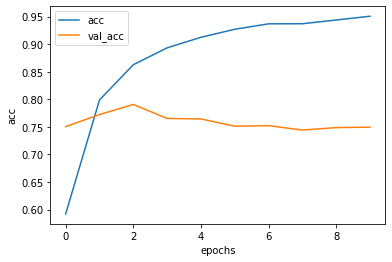

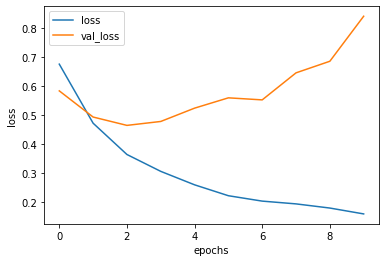

In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "acc")
plot_graphs(history, "loss")


In [0]:
sample_sub=pd.read_csv('/content/sample_submission (1).csv')


In [21]:
sample_sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [0]:
tests_sentences = test['text']
tests_sequences = tokenizer.texts_to_sequences(tests_sentences)
tests_padded = pad_sequences(tests_sequences,maxlen = max_length, truncating=trunc_type, padding=padding_type)

In [0]:
tests_padded_final = np.array(tests_padded)
y_pre=model.predict(tests_padded_final)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [24]:
sub.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
